In [1]:
import tensorflow as tf
import numpy as np
import os

/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
tf.__version__ #check TensorFlow version to ensure compatibility

'2.0.0-beta1'

#### Load data from Train folder

In [3]:
# use pathlib library to access to files & folers
import pathlib
data_root = pathlib.Path('./train')

In [4]:
import random
all_image_paths = list(data_root.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

25000

#### Load data from Test folder

* Print out some images in the folders

In [6]:
all_image_paths[:5]

['train/cat.7327.jpg',
 'train/cat.10465.jpg',
 'train/dog.9872.jpg',
 'train/cat.9126.jpg',
 'train/dog.8132.jpg']

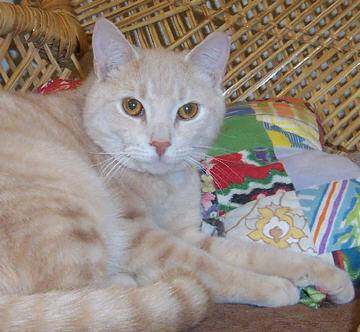

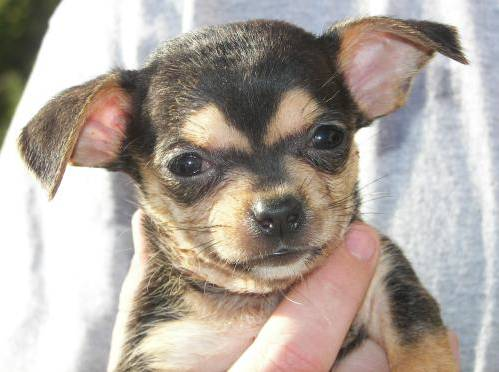

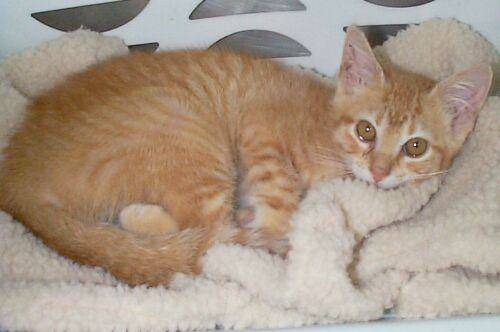

In [7]:
import IPython.display as display

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print()

In this case, we only have dog and cat labels so we will define it.

In [8]:
label_names = ['dog', 'cat']

In [9]:
label_to_index = dict((NAME, index) for index, NAME in enumerate(label_names))
label_to_index

{'cat': 1, 'dog': 0}

In [10]:
all_image_labels = [label_to_index[pathlib.Path(path).name[:3]]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 1, 0, 1, 0, 0, 0, 0, 1, 0]


Define helper to read and resize image

In [11]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)a

Test the helper function with the first image in Train folder

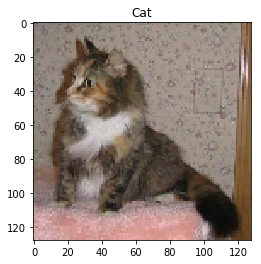

In [12]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.title(label_names[label].title())
plt.show()

In [13]:
# Slicing the array of strings, results in a dataset of strings:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [14]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((128, 128, 3), ()), types: (tf.float32, tf.int32)>

In [15]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

Create train and test datasets (80/20)

In [16]:
train_size = int(0.8 * image_count)
test_size = int(0.20 * image_count)

ds = ds.shuffle(buffer_size = 1024)
train_dataset = ds.take(train_size)
test_dataset = ds.skip(train_size)
test_dataset = ds.take(test_size)

Create Convolutional Neural Network

In [17]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(2, activation='softmax'))

# Compile model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [19]:
# steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
cnn_model.fit(train_dataset, epochs=1)

W0823 10:36:30.867394 140148042786560 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


20000/20000 [==============================] - 5508s 275ms/step - loss: 0.0895 - accuracy: 0.9609


In [20]:
cnn_model.evaluate(test_dataset)

5000/5000 [==============================] - 480s 96ms/step - loss: 0.0192 - accuracy: 0.9943


[0.0191512524166219, 0.9943]

In [23]:
cnn_model.save('BackstreetBoys1.h5')